Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.  
<b>Before you proceed to the code, read the references below:</b>  
http://cs224d.stanford.edu/syllabus.html  
http://cs224d.stanford.edu/lecture_notes/LectureNotes1.pdf

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import urllib
import zipfile
from matplotlib import pylab
import tensorflow as tf # import tensorflow after the matplotlib(bug in tensorflow)
from sklearn.manifold import TSNE

(Don't do this) Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    print statinfo.st_size
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print 'Data size', len(words)

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000
def build_dataset(words):
  count = [['UNK', -1]] # -1 is a dummy value for the count
  # refer to: https://docs.python.org/3/library/collections.html#collections.Counter
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count: ## make dictionary of common words and assign indices(to reverse later)
    dictionary[word] = len(dictionary)
  data = list() # list to store the corresponding indices in the dictionary of common words, for each word in 'words'.
  unk_count = 0
  for word in words:
    if word in dictionary: # if 'word' is a common word, add to dictionary
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))  # swap position of keys and values
  #refer to http://www.tutorialspoint.com/python/dictionary_values.htm, http://www.tutorialspoint.com/python/dictionary_keys.htm
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK)', count[:5]
print 'Sample data', data[:10]
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0
# code to allocate words with labels(context) from the words within the same window
def generate_batch(batch_size, num_skips, skip_window): # batch size: number of batch samples to use, since we use SGD
  global data_index
  assert batch_size % num_skips == 0 # to use batch_size/num_skips as the number of slides
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # visual structure: [ skip_window    target   skip_window ]
  buffer = collections.deque(maxlen=span) # create a window of length 'span'
  for _ in range(span): # enqueue words in the window until the window is full
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) # similar reason for circluar cue(when the data is almost at the end)
  for i in range(batch_size / num_skips):
    target = skip_window  # target label at the center of the buffer(start from the center). always at the center of buffer.
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips): # num_skips: number of words to use as a context for the target, within a fixed window
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target) # exclude the target from the next step
      batch[i * num_skips + j] = buffer[skip_window] 
      labels[i * num_skips + j, 0] = buffer[target]
    # slide the window to the right. i.e. enqueue from the right end, dequeue from the left end
    # refer to collections.deque: https://docs.python.org/2/library/collections.html#collections.deque
    # Here, data_index should be the index of the element next to the right end of the buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print '----batch['+str(i)+']----'
  print batch[i], '->', labels[i, 0]
  print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]
  

----batch[0]----
3084 -> 12
originated -> as
----batch[1]----
3084 -> 5239
originated -> anarchism
----batch[2]----
12 -> 3084
as -> originated
----batch[3]----
12 -> 6
as -> a
----batch[4]----
6 -> 12
a -> as
----batch[5]----
6 -> 195
a -> term
----batch[6]----
195 -> 2
term -> of
----batch[7]----
195 -> 6
term -> a


Train a skip-gram model with Negative Sampling.  
Parameters subject to training are `embeddings, softmax_weights, softmax_biases`  
also refer to:  
  
<b>Standford Lecture Note</b>: http://cs224d.stanford.edu/lecture_notes/LectureNotes1.pdf  
`embeddings` = $h^(i)$, `softmax_weights` = $W^(2)$ in the Standford Lecture Note.  
In tensorflow, rather than multiplying $W^(1)$ to $x$(one-hot encoded input) to earn $h$, it directly uses sets of $h$ as a matrix of embeddings.
  
<b>API</b>
- https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#embedding_lookup
- https://www.tensorflow.org/versions/r0.7/api_docs/python/array_ops.html#gather
- https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#sampled_softmax_loss
- https://www.tensorflow.org/versions/r0.7/api_docs/python/math_ops.html#reduce_mean  
<b>Note: tensorflow tutorial is flawed in explanation</b>   https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html#vector-representations-of-words

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
# draw total of 'valid_size' samples from 0 to 'valid_window' examples
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size]) # where batch data will be stored
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  # 'embeddings' corresponds to W(1) in stanford Lecture Note, and softmax_weights to W(2).
  # each row in 'embeddings' are embedded representation of the original word
  # Stanford Lecture Note: http://cs224d.stanford.edu/lecture_notes/LectureNotes1.pdf
  embeddings = tf.Variable(tf.random_uniform(shape=[vocabulary_size, embedding_size], minval=-1.0, maxval=1.0))
  softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # refer to: http://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do
  # note that 'train_dataset' holds the indices for words in batch dataset
  # in the embeddings matrix, extract the corresponding rows for each center of batch data
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,\
                                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]] # take i-th word from a validation set
        top_k = 8 # number of nearest neighbors to the i-th valid_word
        nearest = (-sim[i, :]).argsort()[1:top_k+1] # extract indices of top k sorted words by the similarity between i-th valid_word
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k): # print
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print log
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 7.93079853058
Nearest to has: sidelined, monopolistic, strident, plight, orthopedic, patenting, technological, halliwell,
Nearest to also: wares, fertilizers, size, decree, vasa, forgotten, probabilistic, temperatures,
Nearest to a: nimzowitsch, net, armadillo, fugitives, aha, refueling, toulouse, sapir,
Nearest to UNK: gangetic, zen, shameful, offutt, fulvia, lowball, superluminal, norris,
Nearest to over: quality, seaport, guadalajara, liquidated, entrance, presenter, trillion, iqaluit,
Nearest to than: horizon, erase, achill, harkonnen, idealist, wacky, island, crucial,
Nearest to system: glaukos, prescott, bunyip, torque, janis, basal, drill, raphael,
Nearest to during: outpost, implicit, juventus, ruining, sejanus, redox, onyx, mes,
Nearest to war: sizable, ingots, nonpolar, deepening, filings, functionality, graduation, romana,
Nearest to often: carmine, dweller, nonterminals, competing, gogo, classis, distributions, zacharias,
Nearest to not:

In [11]:
num_points = 400
# refer to: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :]) # choose total of num_points examples

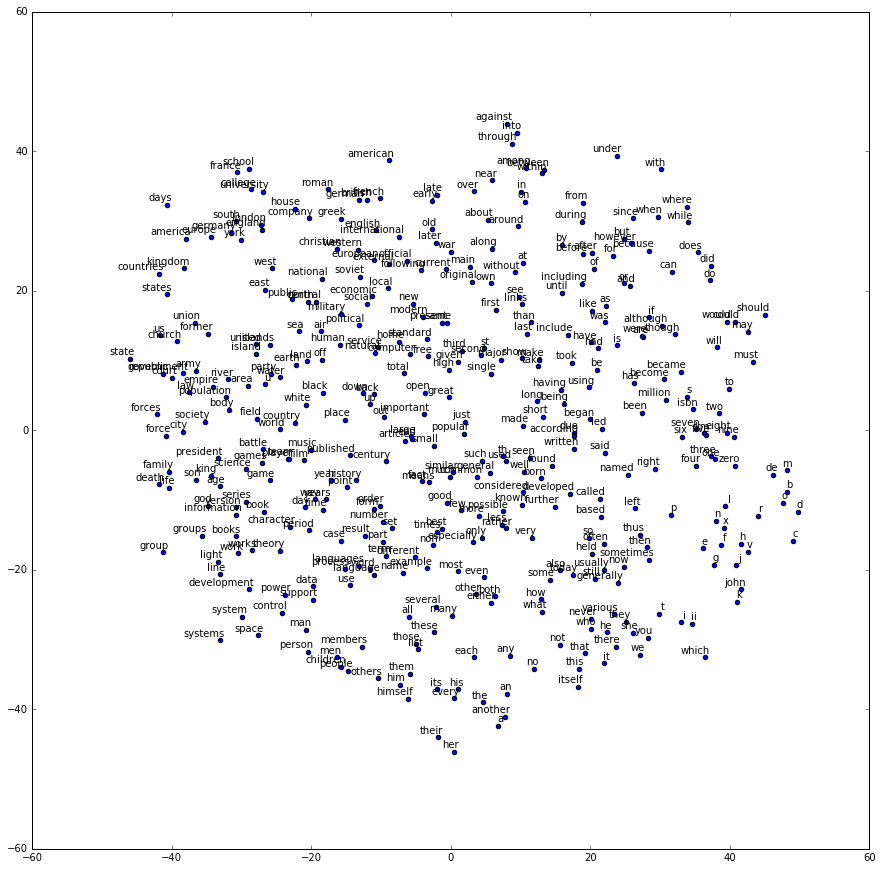

In [12]:
% matplotlib inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---